# import + functions

In [184]:
## Import

import os
import scipy.io
import numpy as np
import os, importlib
import matplotlib.pyplot as plt
import statistics
import scipy.stats
import matplotlib.patches as mpatches
import tkinter as tk
import pandas as pd
import pickle
from open_ephys.analysis import Session
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
from moviepy.editor import *
import glob


## Functions

def diff(data):
    diff = []
    for i in range(1,len(data)):
        diff = diff + [data[i] - data[i-1]]
    return(diff)

def create_spike_time_vectors(spike_times,clusters):
    spiketimevectors = []
    for i in np.unique(clusters):
        spiketimevectors = spiketimevectors + [spike_times[np.where(clusters==i)[0]]]
    return spiketimevectors

def SaveFig(file_name,figure_dir):
    if os.path.isfile(figure_dir + file_name ):
        os.remove(figure_dir + file_name)  
    if not os.path.isdir(figure_dir):
        os.makedirs(figure_dir)
    plt.savefig(figure_dir + file_name)
    plt.close()
    

def Reformat_PokeEphysTS(PokeIn_EphysTS):
    P1_PokeIn_EphysTS = np.array([])
    P2_PokeIn_EphysTS = np.array([])
    for ind, item in enumerate(PokeIn_EphysTS):
        if ind > 0:
            P1_PokeIn_EphysTS = np.append(P1_PokeIn_EphysTS,[PokeIn_EphysTS[ind-1]])
            
            if item == 'NaN':
                P2_PokeIn_EphysTS = np.append(P2_PokeIn_EphysTS,[np.nan])
            else:
                P2_PokeIn_EphysTS =  np.append(P2_PokeIn_EphysTS,[item])
    return np.array(P1_PokeIn_EphysTS),P2_PokeIn_EphysTS



## new version for new open ephys tools 
def align_open_ephys_processors(main_processor_tuple, aux_processor_tuples,raw_data_directory, sync_channel=1):

    session_data = Session(str(raw_data_directory))
    if len(session_data.recordnodes) != 1:
        raise ValueError("should be exactly one record node.")
    if len(session_data.recordnodes[0].recordings) != 1:
        raise ValueError("Should be exactly one recording.")
    for rn, recordnode in enumerate(session_data.recordnodes):
        for r, recording in enumerate(recordnode.recordings):
            # Synch
            recording.add_sync_line(
                sync_channel,
                main_processor_tuple[0],
                main_processor_tuple[1],
                main=True,
            )
            for aux_processor in aux_processor_tuples:
                recording.add_sync_line(
                    sync_channel,
                    aux_processor[0],
                    aux_processor[1],
                    main=False,
                )
            print('this should be zero:')
            print(rn)
        
    return recording


def sequence_contains_sequence(haystack_seq, needle_seq, string):
    start_index = []
    for i in range(0, len(haystack_seq) - len(needle_seq) + 1):
        if needle_seq == haystack_seq[i:i+len(needle_seq)]:
            start_index = start_index + [i]
            print(string + ' barcode found')
    return start_index

def find_first_poke_times(trial_id,ports, poke_in_array):

    first_poke_index = []
    count = 1

    for index,item in enumerate(trial_id):
        if item == count:
            if ports[index] == 2:
                count = count + 1
                first_poke_index = first_poke_index + [index]
            
    return poke_in_array[np.array(first_poke_index)]

def align_firstpoke_camera_timestamps(trial_id,Trial_start_ts,All_Port_references_sorted):
    counter = 0
    trial_ts_aligned = []
    for index,item in enumerate(trial_id):
        if All_Port_references_sorted[index] == 2.0:
            if item > counter:
                counter = counter + 1
                #getting an error 05/01/22 -> I think if the next trial started (TTL went high) but no poke was recorded then there wont be a poke timestamp so account for this: 
                if not len(Trial_start_ts) == counter - 1:
                    trial_ts_aligned = trial_ts_aligned + [Trial_start_ts[counter-1]]
                else:
                    trial_ts_aligned = trial_ts_aligned + ['NaN']
            else:
                trial_ts_aligned = trial_ts_aligned + ['NaN']
        else:
            trial_ts_aligned = trial_ts_aligned + ['NaN']
    return trial_ts_aligned

def align_trial_start_end_timestamps(trial_id,Trial_start_ts):
    trial_ts_aligned = []
    counter = 1
    for index, item in enumerate(trial_id):
        if counter ==  item:
            trial_ts_aligned = trial_ts_aligned + [Trial_start_ts[counter-1]]
        else:
            counter = counter + 1
            trial_ts_aligned = trial_ts_aligned + [Trial_start_ts[counter-1]]
    
    return trial_ts_aligned
            

def clock_find_first_poke_times(trial_id,ports, poke_in_array,trial_seqs):

    first_poke_index = []
    count = 1

    for index,item in enumerate(trial_id):
        if item == count:
            if ports[index] == trial_seqs[index][0]:
                count = count + 1
                first_poke_index = first_poke_index + [index]
            
    return poke_in_array[np.array(first_poke_index)]

def clock_align_firstpoke_camera_timestamps(trial_id,Trial_start_ts,All_Port_references_sorted,trial_seqs):
    counter = 0
    trial_ts_aligned = []
    for index,item in enumerate(trial_id):
        if All_Port_references_sorted[index] == trial_seqs[index][0]:
            if item > counter:
                counter = counter + 1
                #getting an error 05/01/22 -> I think if the next trial started (TTL went high) but no poke was recorded then there wont be a poke timestamp so account for this: 
                if not len(Trial_start_ts) == counter - 1:
                    trial_ts_aligned = trial_ts_aligned + [Trial_start_ts[counter-1]]
                else:
                    trial_ts_aligned = trial_ts_aligned + ['NaN']
            else:
                trial_ts_aligned = trial_ts_aligned + ['NaN']
        else:
            trial_ts_aligned = trial_ts_aligned + ['NaN']
    return trial_ts_aligned

def AlignToTriggersAndFIndEphysTimestamps(Port_intimes,trial_id,first_poke_times,trial_start,TrialStart_EphysTime,FirstPoke_EphysTime):

    new_TS = []
    for index, trial in enumerate(trial_id):
        if np.isnan(Port_intimes[index]):
            new_TS = new_TS + [np.nan]
        else:

            current_poke_event_time = Port_intimes[index]

            # find ech relevant timestamps
            CurrentTrial_startTS = trial_start[trial-1]
            First_pokeTS = first_poke_times[trial-1]

            # last trial has no next trial start
            if trial == trial_id[-1]:
                NextTrial_startTS = 9999999999999
            else:
                NextTrial_startTS = np.unique(trial_start)[trial]

            # find the ts current poke event is closest to
            trialstart_diff =  abs(CurrentTrial_startTS - current_poke_event_time)

            EphysTS = TrialStart_EphysTime[trial-1]
            current_dist = current_poke_event_time - CurrentTrial_startTS 
            distance = EphysTS + current_dist

            new_TS = new_TS + [distance]
            
    return(new_TS)

def Determine_Transition_Times_and_Types(All_PortIn_Times_sorted ,All_PortOut_Times_sorted, All_Port_references_sorted):
    out_in= []
    in_in = []
    transition_type = []
    out_in_transition_reference = []
    in_in_transition_reference = []
    for index,port in enumerate(All_Port_references_sorted):
        if index > 0:
            out_in = out_in + [All_PortIn_Times_sorted[index] - All_PortOut_Times_sorted[index-1] ]
            out_in_transition_reference = out_in_transition_reference + [All_PortOut_Times_sorted[index-1]]

            in_in = in_in + [All_PortIn_Times_sorted[index] - All_PortIn_Times_sorted[index-1] ]
            in_in_transition_reference = in_in_transition_reference + [All_PortIn_Times_sorted[index-1]]

            transition_type = transition_type + [int(str(All_Port_references_sorted[index-1]) + str(port))]

    return (np.array(out_in),np.array(in_in) ,np.array(transition_type),out_in_transition_reference,in_in_transition_reference)

def Determine_transition_matrix(prev_port,current_port):
    Transition = (prev_port * 10) + current_port
    return Transition

def Start_End_port_id(Transition_types,start_end_arg):
    output = []
    for item in Transition_types:
        String = str(item)
        output = output + [int(String[start_end_arg])]
    return output

def determine_RepeatPort_events(start_port_ids,end_port_ids):
    Port_repeat = []
    for index, item in enumerate(start_port_ids):
        if item == end_port_ids[index]:
            Port_repeat = Port_repeat + [0]
        else: 
            Port_repeat = Port_repeat + [1]
    return Port_repeat    

def filter_transitons_by_latency(Transition_times, Upper_Filter):
    Filtered_transitions = []
    for item in Transition_times:
        if item < Upper_Filter:
            Filtered_transitions = Filtered_transitions + [1]
        else:
            Filtered_transitions = Filtered_transitions + [0]
    return Filtered_transitions

def find_files(filename, search_path):
    result = []

    #Walking top-down from the root
    for root, dir, files in os.walk(search_path):
        if filename in files:
            result.append(os.path.join(root, filename))

    return result

def find_folder_path(parent_folder, target_folder):
    for root, dirs, files in os.walk(parent_folder):
        if target_folder in dirs:
            return os.path.join(root, target_folder)
        # If the target folder is not found
    return (print('not found'))

def test_timestamps_(Trial_start_ts,Trial_start_Camera_Ts):
    working = False
    try:
        trial_start_difference = (np.diff(Trial_start_ts) - np.diff(Trial_start_Camera_Ts)[0:-1])
        working = True

    except:
        print('broken - being fixed')
        tester = False
        while tester == False:
            Trial_start_Camera_Ts,tester = fix_missing_triggers(Trial_start_ts,Trial_start_Camera_Ts)
            print('fixed')
        print('all fixed')
    try:
        trial_start_difference = (np.diff(Trial_start_ts) - np.diff(Trial_start_Camera_Ts)[0:-1])
        working = True
        print('working')
    except:
        print('fail')

    for item in (trial_start_difference):
        if abs(item) > 1:
            raise NameError('Test not passed, Timestamps dont line up!')

    print('test passed!')
    
    Trial_start_Camera_Ts= Trial_start_Camera_Ts
    
    return Trial_start_Camera_Ts

def fix_missing_triggers(Trial_start_ts,Trial_start_Camera_Ts):

    fixed_trial_strart_ts= []
    for index,item in enumerate(np.diff(Trial_start_ts)):
        if abs(item - np.diff(Trial_start_Camera_Ts)[index]) > 1:
#             missing_trigger = Trial_start_Camera_Ts[index]+np.diff(Trial_start_ts)[index]
            missing_trigger = np.nan
            fixed_trial_strart_ts = np.insert(Trial_start_Camera_Ts,index+1,[missing_trigger])
            print(index)
            break
    
    try:
        trial_start_difference = (np.diff(Trial_start_ts) - np.diff(fixed_trial_strart_ts)[0:-1])
        for item in (trial_start_difference):
            if abs(item) > 1:
                tester = False
            else:
                tester = True
    except:
        tester = False

    return fixed_trial_strart_ts, tester


def align_to_start_ts(trials,fixed_cam_ts):
    Camera_timestamps = []
    Camera_time = []
    for trial in trials :
        Camera_timestamps.append(fixed_cam_ts[trial-1])
        Camera_time.append(fixed_cam_ts[trial-1])
    return Camera_timestamps,Camera_time

## alignment: 
def align_allpokes_to_cam_trialstart(Trials,trial_start_bpod_ts,PokeIn_Time,Fixed_back_cam_tstart_ts):

    cam_poke_times = []
    for index,trial in enumerate(Trials):
        bpod_trial_start = trial_start_bpod_ts[trial-1]
        poke_time = PokeIn_Time[index]
        diff = poke_time - bpod_trial_start
        cam_poke_times = cam_poke_times + [(Fixed_back_cam_tstart_ts[trial-1]) + diff]

    return cam_poke_times

def Determine_Transition_Times_and_Types(All_PortIn_Times_sorted ,All_PortOut_Times_sorted, All_Port_references_sorted):
    out_in= []
    in_in = []
    transition_type = []
    out_in_transition_reference = []
    in_in_transition_reference = []
    for index,port in enumerate(All_Port_references_sorted):
        if index > 0:
            out_in = out_in + [All_PortIn_Times_sorted[index] - All_PortOut_Times_sorted[index-1] ]
            out_in_transition_reference = out_in_transition_reference + [All_PortOut_Times_sorted[index-1]]

            in_in = in_in + [All_PortIn_Times_sorted[index] - All_PortIn_Times_sorted[index-1] ]
            in_in_transition_reference = in_in_transition_reference + [All_PortIn_Times_sorted[index-1]]

            transition_type = transition_type + [int(str(All_Port_references_sorted[index-1]) + str(port))]

    return (np.array(out_in),np.array(in_in) ,np.array(transition_type),out_in_transition_reference,in_in_transition_reference)


def Start_End_port_id(Transition_types,start_end_arg):
    output = []
    for item in Transition_types:
        String = str(item)
        output = output + [int(String[start_end_arg])]
    return output

def determine_RepeatPort_events(start_port_ids,end_port_ids):
    Port_repeat = []
    for index, item in enumerate(start_port_ids):
        if item == end_port_ids[index]:
            Port_repeat = Port_repeat + [0]
        else: 
            Port_repeat = Port_repeat + [1]
    return Port_repeat    

def filter_transitons_by_latency(Transition_times, Upper_Filter):
    Filtered_transitions = []
    for item in Transition_times:
        if item < Upper_Filter:
            Filtered_transitions = Filtered_transitions + [1]
        else:
            Filtered_transitions = Filtered_transitions + [0]
    return Filtered_transitions

# Choose data to process:

In [6]:
probe = 'probeA'
index = 0

#sample rate:
Fs = 30000.0

## gather all raw ephys paths
path_ = r"Z:\projects\sequence_squad\revision_data\lars_recordings\ephys\\"
base_recording_paths = []
for q in os.listdir(path_):
    if not 'other_sessions' in q:
        folder = os.path.join(path_,q)
        for q in os.listdir(folder):
            base_recording_paths+=[os.path.join(folder,q)]
            

# gather the corespoding organised paths for each raw dat file 
organised_path = r"Z:\projects\sequence_squad\revision_data\organised_data\animals\\"
full_organised_paths = []
for i in range(len(base_recording_paths)):
    mouse_id = base_recording_paths[i].split('\\')[-1].split('_')[0]
    date_ = base_recording_paths[i].split('\\')[-1].split('_')[1]
    #reverse the date
    date_ = '-'.join(date_.split('-')[::-1])
    
    organised_path_animal = os.path.join(organised_path,mouse_id+'_implant1')

    for recording in os.listdir(organised_path_animal):
        if date_ in recording:
            full_organised_paths += [os.path.join(organised_path_animal,recording)]
            break


for index in range(len(base_recording_paths)):
    print(index)
    index = 3
       
    # set important paths 
    raw_data_directory = base_recording_paths[index]
    print(raw_data_directory)
    OE_processor_path = find_folder_path(raw_data_directory, "continuous") 
    Behav_data_path = full_organised_paths[index]+ r'//behav_sync/2_task/Preprocessed//'

    Processed_Ephys_data_path = full_organised_paths[index]+ r'/ephys//' + probe + r'/kilosort4_output/sorter_output//'
    
    organised_ephys_path = full_organised_paths[index]+ r'/ephys//'

    if probe in os.listdir(full_organised_paths[index]+ r'/ephys//'):
        if 'unit_info.txt' in os.listdir(full_organised_paths[index]+ r'/ephys//' + probe):
            print('All good! Data is kilosorted')
            
            print(os.listdir(full_organised_paths[index]+ r'/ephys//'))
            print(raw_data_directory)
            print(OE_processor_path)
            print(Behav_data_path)
            print(Processed_Ephys_data_path)
            break
        else:
            print('data not yet kilosorted, skip!')
    else:
        print('data not yet kilosorted, skip!')
        
        
### add to this... if its already been run then also skip...
    

print(index)



0
Z:\projects\sequence_squad\revision_data\lars_recordings\ephys\\ap5\ap5R_2024-11-26_09-29-29_ap5_488
All good! Data is kilosorted
['global-timstamps_event-df.pkl', 'probeA']
Z:\projects\sequence_squad\revision_data\lars_recordings\ephys\\ap5\ap5R_2024-11-26_09-29-29_ap5_488
Z:\projects\sequence_squad\revision_data\lars_recordings\ephys\\ap5\ap5R_2024-11-26_09-29-29_ap5_488\Record Node 105\experiment1\recording1\continuous
Z:\projects\sequence_squad\revision_data\organised_data\animals\\ap5R_implant1\recording7_26-11-2024//behav_sync/2_task/Preprocessed//
Z:\projects\sequence_squad\revision_data\organised_data\animals\\ap5R_implant1\recording7_26-11-2024/ephys//probeA/kilosort4_output/sorter_output//
3


In [5]:
# to do...
# decide which units to keep and throw... 
## this script also needs to deal with the probe B stuff...

# choose which units to keep based on LFP spectral power? 

In [6]:
 ### load in spectral power data and use this to make a decision... 
 
 ## then make spikes files from this
 
 ### then in the rest of this doc make the alignment stuff... 
 
 
 
 
# #### Make spike time vectors: 

# # load in spike data and curation file:
# spike_times = np.load(Processed_Ephys_data_path + 'spike_times.npy')
# spike_times = (np.concatenate(spike_times))/Fs
# clusters = np.load(Processed_Ephys_data_path + 'spike_clusters.npy')

# # Manual_Score = pd.read_csv(Processed_Ephys_data_path + 'cluster_group.tsv', sep='\t')

# Manual_Score = pd.read_csv(Processed_Ephys_data_path + 'cluster_KSLabel.tsv', sep='\t')

# Sort spike data into vectors that can be rasters. ie. single clusters and all spike times in ephys time 

# create spike time vectors for all clusters, adjus for start time offset:
# spiketimevectors = create_spike_time_vectors(spike_times,clusters)

# pull out curation scores for each cluster

# Mscore = list(Manual_Score.loc[:,'group'])
# clusterid = list(Manual_Score.loc[:,'cluster_id'])

# Mscore = list(Manual_Score.loc[:,'KSLabel'])
# clusterid = list(Manual_Score.loc[:,'cluster_id'])


# Sort these by good/bad manual clustering scores
# filter spike vectors by manual curation scores:
# CuratedeSpikeTimeVectors = []
# CuratedSpikeClusterIds= []
# for index,ids in enumerate(clusterid):
#     if Mscore[index] == 'good':
#         ind = np.where(np.unique(clusters) == ids)[0][0]
#         CuratedeSpikeTimeVectors = CuratedeSpikeTimeVectors + [spiketimevectors[ind]]
#         CuratedSpikeClusterIds = CuratedSpikeClusterIds + [ids]
        
# print('Total curated clusters = ' + str(len(CuratedeSpikeTimeVectors)))

## Save out curated spike time clusters:

# if not os.path.isdir(output_path):
#     os.makedirs(output_path)
    
# filename = 'Curated_Cluster-Ids'
# with open(output_path  + '/' + filename, 'wb') as fp:
#     pickle.dump(CuratedSpikeClusterIds,fp)
    
# filename = 'Curated_Cluster-SpikeTimes'
# with open(output_path + '/' + filename, 'wb') as fp:
#     pickle.dump(CuratedeSpikeTimeVectors,fp)

# Load in raw ephys data and compute gloabl timestamps 

In [7]:
import re
count = 0
for processor in os.listdir(OE_processor_path):
    if count == 0:
        main1 = int(re.findall(r'\d+', processor)[0])
        main1_2 = processor.split('.')[-1]
    elif count == 1:
        main2 = int(re.findall(r'\d+', processor)[0])
        main2_2 = processor.split('.')[-1]
    elif count == 2:
        main3 = int(re.findall(r'\d+', processor)[0])
        main3_2 = processor.split('.')[-1]
    count +=1 

main_processor_tuple=(main1, main1_2)

aux_processor_tuples=((main2,main2_2),(main3,main3_2))


############ DONT RUN MORE THAN ONCE! ITS SO SLOW! ######################

### LOAD in data: this could take a few minutes

# check to see if global object alreayd exists and fi it does... load premade one instead of doing it the slow way 
if not 'global-timstamps_event-df.pkl' in os.listdir(organised_ephys_path):
    
    recording = align_open_ephys_processors(main_processor_tuple,aux_processor_tuples,raw_data_directory)
    recording.compute_global_timestamps()
    
    ## Save this out:
    print('saving...')
    if not os.path.isdir(organised_ephys_path):
        os.makedirs(organised_ephys_path)
    save_path = organised_ephys_path + f"global-timstamps_event-df.pkl"
    recording.events.to_pickle(save_path)
    
    ## Extract timestamp data:
    events_df= recording.events
    
else:
    print('already computed, loading...')
    events_df = pd.read_pickle(organised_ephys_path + 'global-timstamps_event-df.pkl')
    
############ DONT RUN MORE THAN ONCE! ITS SO SLOW! ######################

# i believe line 2 is the 2nd ttl line which carries the Bpod TTLs to the nidaq
Bpod_NIDAQ_TTLS = events_df[events_df.line == 2]

### sort out offset:
sync_messages_path = find_files("sync_messages.txt",raw_data_directory)[0]
sync = open(sync_messages_path, 'r')
lines = sync.readlines()
for line in lines:
    if 'Neuropix-PXI' in line:
        if 'ProbeA-AP' in line:
            print(line)
            start_time_offset = int(re.findall(r'\d+', line)[-1]) / Fs
            print(start_time_offset)



already computed, loading...
Start Time for Neuropix-PXI (106) - ProbeA-AP @ 30000 Hz: 354012

11.8004


# find the start of each behavioural epoch (sleep, task, sleep)

behaviour barcode found
behaviour barcode found
presleep barcode found


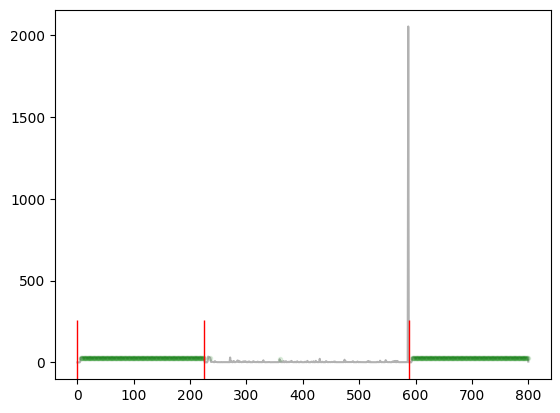

In [8]:
## find barcode indicies: 

Behaviour_barcode = np.array([0.05, 1.  , 0.05, 0.5 , 0.05, 1.  , 0.05, 0.5 , 0.05, 0.5 , 0.05]) #LSLSSS (last gap cant be seen as no pulse after it...)
Clock_barcode = np.array([0.05, 1.  , 0.05, 0.5 , 0.05, 1.  , 0.05, 0.5 , 0.05, 1.0 , 0.05]) # LSLSLS
presleep_barcode = np.array([0.05, 0.5  , 0.05, 0.5 , 0.05, 1.  , 0.05, 0.5 , 0.05, 0.5 , 0.05]) # SSLSSS
postsleep_barcode = np.array([0.05, 1.  , 0.05, 0.5 , 0.05, 0.5  , 0.05, 0.5 , 0.05, 0.5 , 0.05]) # LSSSSS


behaviour_barcode_index = sequence_contains_sequence(list(np.round(np.diff(Bpod_NIDAQ_TTLS['global_timestamp']),2)),list(Behaviour_barcode), 'behaviour')
presleep_barcode_index = sequence_contains_sequence(list(np.round(np.diff(Bpod_NIDAQ_TTLS['global_timestamp']),2)),list(presleep_barcode), 'presleep')[0]
postsleep_barcode_index = behaviour_barcode_index[-1]


### there should always be a pre and post sleep barcode... but sometimes not a behaviour one.. so instead I need to just work out the point when the first camera ts ends

## split into 3 sperates epochs based on triggers
# find trigger onset times
trigger_onset_times = Bpod_NIDAQ_TTLS[Bpod_NIDAQ_TTLS.state == 0]['global_timestamp']

sleep_trigger_inds = np.where((np.diff(trigger_onset_times) > 28.5) & (np.diff(trigger_onset_times) < 31.5))[0]

plt.plot(np.diff(Bpod_NIDAQ_TTLS['global_timestamp'])[1::2], color = 'k', alpha = 0.3)
plt.plot(np.array(sleep_trigger_inds),np.diff(Bpod_NIDAQ_TTLS['global_timestamp'])[1::2][sleep_trigger_inds],'o',alpha = 0.1, color = 'green',markersize = 3)

consecutive_chunks = []
start = None
for i in range(len(sleep_trigger_inds) - 1):
    if sleep_trigger_inds[i + 1] - sleep_trigger_inds[i] == 1:
        if start is None:
            start = sleep_trigger_inds[i]
    else:
        if start is not None:
            end = sleep_trigger_inds[i]
            consecutive_chunks.append((start*2, end*2))
            start = None
if start is not None:
    # *2 because the original array was the diff of the TTL on and off periods and this is just TTL onsets
    consecutive_chunks.append((start*2, sleep_trigger_inds[-1]*2))
    
plt.plot(consecutive_chunks[0][-1]/2,0,'|',markersize = 60, color = 'red')
plt.plot(presleep_barcode_index/2,0,'|',markersize = 60, color = 'red')
plt.plot(postsleep_barcode_index/2,0,'|',markersize = 60, color = 'red')


behaviour_barcode_index = consecutive_chunks[0][-1]

# load behaviour and check alignment

In [9]:
# load in behavioural data           
Full_Behav_data_path = list(os.walk(Behav_data_path))[-1][0]  
poke_data =  pd.read_csv(Full_Behav_data_path + "/PreProcessed_RawPokeData.csv") 

first_poke_times = find_first_poke_times((poke_data['Trial_id']),list(poke_data['Port']), np.array(poke_data['PokeIn_Time']))
all_timestamps = sorted(list(first_poke_times) + list(np.unique(poke_data['Trial_Start'])))

(-0.1, 0.1)

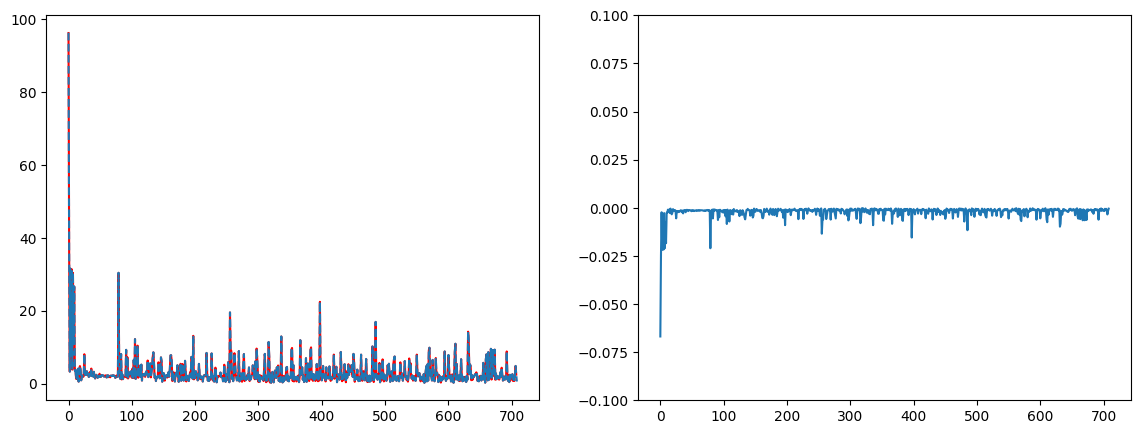

In [42]:
## plot the timestamps (difffernces) to see if they overlay perfectly 

## adjust as needed 
manual_offset = 15

NIDAQ_ts_diff = np.diff(Bpod_NIDAQ_TTLS['global_timestamp'][behaviour_barcode_index+manual_offset:postsleep_barcode_index])
behaviour_ts_diff = np.diff(all_timestamps)


fig, [ax,ax1] = plt.subplots(1, 2, figsize=(14, 5))
ax.plot(NIDAQ_ts_diff[1:len(behaviour_ts_diff)], color = 'red') ## 1:: because the behaviour starts from diff between trial and first poke while ephys starts from barcode/start point end to trial start 
ax.plot(behaviour_ts_diff,'--')
# ax.set_xlim([0, 120])

## plot the difference between the two to see if there is misalingment between the two timestamp sets: 
plt.plot(NIDAQ_ts_diff[1:len(all_timestamps)] - behaviour_ts_diff)
plt.ylim([-0.1, 0.1])


# Align ephys timestamps and behaviour 

start end diffs
for ephys ts:      2264.0738122563516
for behav ts:      2265.6466


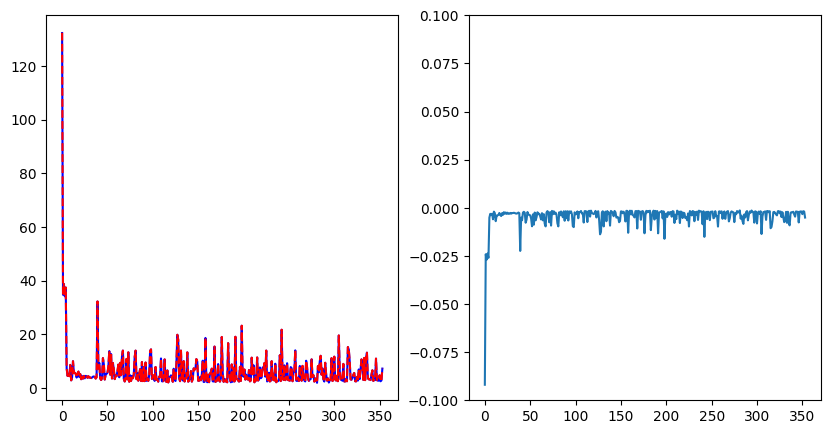

In [43]:
#### align timestamps to behaviour

behav_NIDAQ_events = Bpod_NIDAQ_TTLS[behaviour_barcode_index+manual_offset:postsleep_barcode_index]
all_NIDAQ_TS = behav_NIDAQ_events['global_timestamp'].values

all_states = np.array(behav_NIDAQ_events['state'])
up_ticks_inds = np.where(all_states == 1)
down_ticks_inds = np.where(all_states == 0)

trial_start_TS = np.unique(poke_data['Trial_Start'])
first_poke_TS = np.array(sorted(list(first_poke_times)))

## up ticks - trials start - alignment
aligned_trial_starts_ephys_TS = all_NIDAQ_TS[up_ticks_inds][0:len(trial_start_TS)]


fig, [ax,ax1] = plt.subplots(1, 2, figsize=(10, 5))
ax.plot(np.diff(aligned_trial_starts_ephys_TS), color = 'blue')
ax.plot(np.diff(trial_start_TS), '--',color = 'red')
# plt.xlim([380, 415])
# plt.xlim([60, 100])

ax1.plot(np.diff(aligned_trial_starts_ephys_TS)-np.diff(trial_start_TS))
ax1.set_ylim([-0.1, 0.1])

print('start end diffs')
print('for ephys ts:      '+ str(aligned_trial_starts_ephys_TS[-1] - aligned_trial_starts_ephys_TS[0]))
print('for behav ts:      ' + str(trial_start_TS[-1] -  trial_start_TS[0])) 

(-0.1, 0.1)

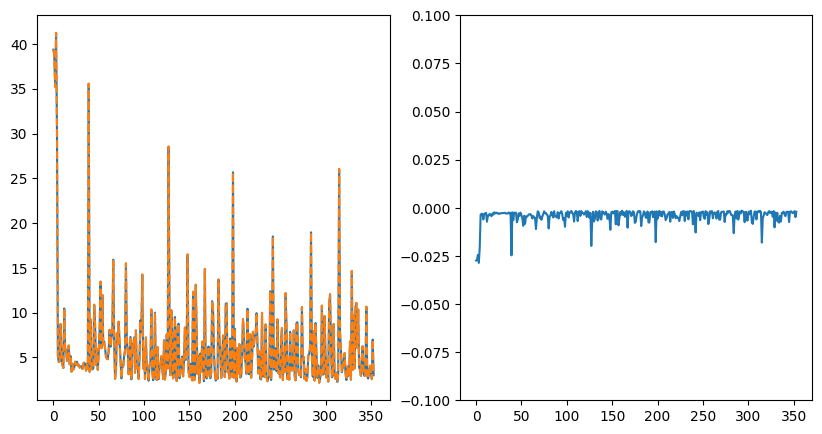

In [45]:
## up ticks - first poke - alignment
fig, [ax,ax1] = plt.subplots(1, 2, figsize=(10, 5))

aligned_first_poke_ephys_TS = all_NIDAQ_TS[down_ticks_inds][1:len(first_poke_TS)+1]

ax.plot(np.diff(aligned_first_poke_ephys_TS))
ax.plot(np.diff(first_poke_TS),'--')
# plt.xlim([380, 415])
# plt.xlim([0, 40])

ax1.plot(np.diff(aligned_first_poke_ephys_TS)-np.diff(first_poke_TS))
ax1.set_ylim([-0.1, 0.1])

# aligne all poke in and out events to nearest ephys trigger

In [46]:
PokeIn_Times = list(poke_data['PokeIn_Time'])
PokeOut_Times = list(poke_data['PokeOut_Time'])
                               
trial_start = list(poke_data['Trial_Start'])
trial_id = list(poke_data['Trial_id'])
                               
PokeInTimes_Ephys_TS = AlignToTriggersAndFIndEphysTimestamps(PokeIn_Times,trial_id,first_poke_TS,trial_start_TS,aligned_trial_starts_ephys_TS,aligned_first_poke_ephys_TS)
PokeOutTimes_Ephys_TS = AlignToTriggersAndFIndEphysTimestamps(PokeOut_Times,trial_id,first_poke_TS,trial_start_TS,aligned_trial_starts_ephys_TS,aligned_first_poke_ephys_TS)

In [47]:
## align to and add to dataframe and then save this out: 

df_aligned_firstpoke_ephys_ts = align_firstpoke_camera_timestamps(list(poke_data['Trial_id']), aligned_first_poke_ephys_TS - start_time_offset ,list(poke_data['Port']))
df_aligned_trialstart_ephys_ts = align_trial_start_end_timestamps(list(poke_data['Trial_id']),aligned_trial_starts_ephys_TS)

poke_data['TrialStart_EphysTime'] = np.array(df_aligned_trialstart_ephys_ts) - start_time_offset
poke_data['FirstPoke_EphysTime'] = df_aligned_firstpoke_ephys_ts

## acount for offset 
PokeIN_EphysTime = np.array(PokeInTimes_Ephys_TS) - start_time_offset
PokeOUT_EphysTime = np.array(PokeOutTimes_Ephys_TS[0:-1]) - start_time_offset  

## hack if there is a NaN at the end:
PokeOUT_EphysTime = np.append(np.array(PokeOutTimes_Ephys_TS[0:-1]) - start_time_offset,'NaN')
poke_data['PokeIN_EphysTime'] = PokeIN_EphysTime 
poke_data['PokeOUT_EphysTime'] = PokeOUT_EphysTime

# poke_data.to_csv(output_path +'/TaskPokeData_camera_ephys_aligned.csv')

Make transition dataframe

In [48]:
Port_intimes = list(poke_data['PokeIn_Time'])
Port_outtimes = list(poke_data['PokeOut_Time'])
Ports = list(poke_data['Port'])

#Determine Transition times and types for all events 
out_in_Transition_times, in_in_Transition_times, Transition_types, out_in_transition_reference,in_in_transition_reference = Determine_Transition_Times_and_Types(Port_intimes,Port_outtimes,Ports)

#Split transtion types into first and last ports: 
start_port_ids = Start_End_port_id(Transition_types,0)
end_port_ids = Start_End_port_id(Transition_types,1)

#Align start and end port time
End_Port_in_time = Port_intimes[1::]
Start_Port_in_time = Port_intimes[0:-1]
End_Port_out_time = Port_outtimes[1::]
Start_Port_out_time = Port_outtimes[0:-1]

#Find Port repeat events (double pokes)
Non_Port_repeat = determine_RepeatPort_events(start_port_ids,end_port_ids)

#Determine which transitions are good: less than 1.5s
out_in_Filtered_transitions = filter_transitons_by_latency(out_in_Transition_times, 2)
in_in_Filtered_transitions = filter_transitons_by_latency(in_in_Transition_times, 2)

In [49]:
# make dataframe:
Transition_df = pd.DataFrame(
    {'Trial_id' : poke_data['Trial_id'][0:-1],
    'Transition_type' : Transition_types,
     'Start_Port':start_port_ids, 
     'End_Port':end_port_ids,
     'Start_Poke_in_time': Start_Port_in_time,
     'Start_Poke_out_time': Start_Port_out_time,
     'End_Poke_in_time': End_Port_in_time,
     'End_Poke_out_time': End_Port_out_time,
     'out_in_Latency' : out_in_Transition_times,
     'in_in_Latency': in_in_Transition_times,
     '2s_Time_Filter_out_in': out_in_Filtered_transitions,
     '2s_Time_Filter_in_in': in_in_Filtered_transitions,
     'Port 2,3,4,5 LED intensities': poke_data['Port 2,3,4,5 LED intensities'][0:-1],
     'Port 1,2,3,4 RewardAmount':poke_data['Port 1,2,3,4 RewardAmount'][0:-1],
     'Repeat_Filter':Non_Port_repeat,
     'P1_IN_Ephys_TS': PokeIN_EphysTime[0:-1],
     'P1_OUT_Ephys_TS': PokeOUT_EphysTime[0:-1],
     'P2_IN_Ephys_TS': PokeIN_EphysTime[1::],
     'P2_OUT_Ephys_TS': PokeOUT_EphysTime[1::]})
    
# #Save Data
# Transition_df.to_csv(output_path +'/TaskTransitionData_camera_ephys_aligned.csv')

# now align the cameras

load in camera ts files

In [105]:
from pathlib import Path
behav_path = '\\'.join(list(Path(organised_ephys_path).parts[0:-1])) + r'\video\videos\2_task\\'
presleep_path = '\\'.join(list(Path(organised_ephys_path).parts[0:-1])) + r'\video\videos\1_presleep\\'
postsleep_path = '\\'.join(list(Path(organised_ephys_path).parts[0:-1])) + r'\video\videos\3_postsleep\\'

# find pre sleep csv file 
csv_files = [f for f in os.listdir(behav_path) if f.endswith('.csv')]
if len(csv_files) > 1:
    raise ValueError("Multiple CSV files found in the postsleep directory.")
behav_cam_ts = pd.read_csv(behav_path + csv_files[0])

# find pre sleep csv file 
csv_files = [f for f in os.listdir(presleep_path) if f.endswith('.csv')]
if len(csv_files) > 1:
    raise ValueError("Multiple CSV files found in the postsleep directory.")
presleep_cam_ts = pd.read_csv(presleep_path + csv_files[0])

# find post sleep csv file 
csv_files = [f for f in os.listdir(postsleep_path) if f.endswith('.csv')]
if len(csv_files) > 1:
    raise ValueError("Multiple CSV files found in the postsleep directory.")
postsleep_cam_ts = pd.read_csv(postsleep_path + csv_files[0])

In [271]:
presleep_cam_ts

,Unnamed: 0,origional_video_ts,Trigger State,Time Stamps
0,0,0.000000,0.0,0.000000
1,1,0.016625,0.0,0.016625
2,2,0.033250,0.0,0.033250
3,3,0.049875,0.0,0.049875
4,4,0.066625,0.0,0.066625
...,...,...,...,...
393240,393240,6560.891125,0.0,6560.891125
393241,393241,6560.907750,0.0,6560.907750
393242,393242,6560.924375,0.0,6560.924375
393243,393243,6560.941125,0.0,6560.941125


In [268]:
behav_cam_ts

,Unnamed: 0,origional_video_ts,Trigger State,Time Stamps
0,0,6561.665750,0.0,0.000000
1,1,6561.682375,1.0,0.016625
2,2,6561.699000,1.0,0.033250
3,3,6561.715750,1.0,0.050000
4,4,6561.732375,1.0,0.066625
...,...,...,...,...
266290,266290,11008.364500,0.0,4446.698750
266291,266291,11008.381125,0.0,4446.715375
266292,266292,11008.397750,0.0,4446.732000
266293,266293,11008.414500,0.0,4446.748750


In [270]:
6561.665750
seconds = 6561.665750
hours = int(seconds // 3600)
minutes = int((seconds % 3600) // 60)
remaining_seconds = seconds % 60
print(f"{hours} hours, {minutes} minutes, {remaining_seconds:.2f} seconds")

1 hours, 49 minutes, 21.67 seconds


blue x should be at uptick - bottom
red should be a downtick - top


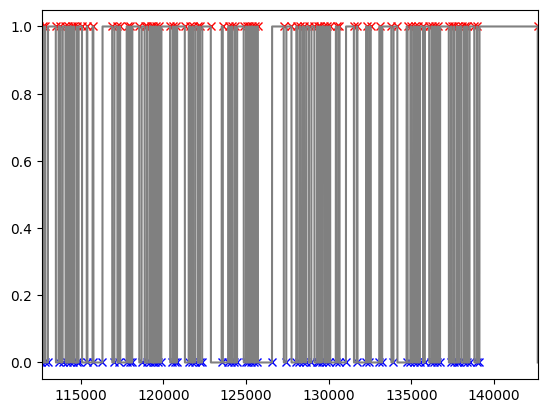

In [115]:
# find camera triggers: 

Camera_trig_states = behav_cam_ts['Trigger State'].values

where_ttl_changes = list(np.where(np.roll(Camera_trig_states,1)!=Camera_trig_states)[0])
if where_ttl_changes[0] == 0:
    where_ttl_changes = where_ttl_changes[1::]

## check this is correct:
plt.plot(np.array(where_ttl_changes[1::2]),np.ones(len(np.array(where_ttl_changes[1::2]))),'x', color = 'red')
plt.plot(np.array(where_ttl_changes[0::2]),np.zeros(len(np.array(where_ttl_changes[0::2]))),'x',color = 'blue')
plt.plot(behav_cam_ts['Trigger State'].values, color = 'grey')
plt.xlim([max(where_ttl_changes)-30000, max(where_ttl_changes)])

print('blue x should be at uptick - bottom')
print('red should be a downtick - top') 

# turn these into time stamp values
Poke1_camera_ts = behav_cam_ts['Time Stamps'].values[np.array(where_ttl_changes[1::2])]
Trial_start_camera_ts= behav_cam_ts['Time Stamps'].values[np.array(where_ttl_changes[0::2])]


In [255]:
poke_data

,Unnamed: 0,Trial_id,Trial_Start,Port,PokeIn_Time,PokeOut_Time,Reward_Times,Trial_End,"Port 2,3,4,5 LED intensities","Port 1,2,3,4 RewardAmount",BACK_Trial_Start_Camera_Time,BACK_Trial_End_Camera_Time,BACK_First_poke_Camera_Time,TrainingLevel,TrialStart_EphysTime,FirstPoke_EphysTime,PokeIN_EphysTime,PokeOUT_EphysTime
0,0,1,15.2224,6,82.7462,82.9945,NaN,147.6291,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",temporary_spacer,temporary_spacer,temporary_spacer,50,6639.485043,NaN,6707.008843,6707.257142837198
1,1,1,15.2224,2,111.4999,111.5000,NaN,147.6291,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",temporary_spacer,temporary_spacer,temporary_spacer,50,6639.485043,6735.695697,6735.762543,6735.762642837199
2,2,1,15.2224,2,111.5002,111.5176,NaN,147.6291,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",temporary_spacer,temporary_spacer,temporary_spacer,50,6639.485043,NaN,6735.762843,6735.780242837198
3,3,1,15.2224,2,111.5219,111.8167,NaN,147.6291,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",temporary_spacer,temporary_spacer,temporary_spacer,50,6639.485043,NaN,6735.784543,6736.079342837198
4,4,1,15.2224,1,113.0116,113.2143,NaN,147.6291,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",temporary_spacer,temporary_spacer,temporary_spacer,50,6639.485043,NaN,6737.274243,6737.476942837198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2694,2694,355,2280.8690,1,2282.0552,2282.1576,NaN,2283.5915,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",temporary_spacer,temporary_spacer,temporary_spacer,50,8903.558855,NaN,8904.745055,8904.84745509355
2695,2695,355,2280.8690,6,2282.4439,2282.4540,NaN,2283.5915,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",temporary_spacer,temporary_spacer,temporary_spacer,50,8903.558855,NaN,8905.133755,8905.143855093549
2696,2696,355,2280.8690,6,2282.4825,2282.5543,NaN,2283.5915,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",temporary_spacer,temporary_spacer,temporary_spacer,50,8903.558855,NaN,8905.172355,8905.24415509355
2697,2697,355,2280.8690,3,2282.8627,2282.9166,NaN,2283.5915,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",temporary_spacer,temporary_spacer,temporary_spacer,50,8903.558855,NaN,8905.552555,8905.60645509355


In [253]:
fixed_Trial_start_camera_ts

array([  54.84075 ,  187.2615  ,  222.078375,  260.893375,  295.1105  ,
        332.6095  ,  339.972625,  344.5205  ,  349.78475 ,  354.232625,
        362.861875,  365.743875,  369.742   ,  379.7705  ,  385.517875,
        391.23175 ,  396.52925 ,  400.444125,  405.85825 ,  412.00525 ,
        416.08675 ,  421.317625,  424.616   ,  429.080625,  432.595625,
        437.160125,  440.79175 ,  445.35625 ,  449.7875  ,  453.635625,
        458.05025 ,  461.965   ,  465.913125,  469.661375,  473.57625 ,
        477.840875,  482.172125,  486.336875,  489.901875,  493.93325 ,
        526.218   ,  533.547875,  542.910125,  546.508375,  549.523625,
        553.221875,  564.4     ,  573.24575 ,  576.427625,  581.392   ,
        586.72275 ,  592.38675 ,  600.399625,  614.193125,  619.19075 ,
        631.88475 ,  635.466375,  644.84525 ,  651.858625,  655.207125,
        659.9715  ,  664.419375,  670.74975 ,  679.51225 ,  683.543625,
        692.9725  ,  697.77025 ,  709.61475 ,  723.591375,  727.

In [254]:
151.128625 - 54.84075

96.287875

In [257]:
151.128625/60

2.5188104166666667

In [259]:
0.5188104166666667 * 60

31.128625000000003

In [251]:
Poke1_camera_ts[2::]

array([ 151.128625,  190.54325 ,  229.474875,  264.70825 ,  305.972125,
        336.15775 ,  341.272   ,  345.736625,  350.31775 ,  359.030375,
        363.74475 ,  367.9095  ,  371.724375,  382.186125,  387.86675 ,
        393.730625,  398.328375,  403.642625,  409.95625 ,  414.187625,
        419.3185  ,  422.716875,  426.99825 ,  430.6465  ,  434.461375,
        438.975875,  443.124   ,  447.6385  ,  451.70325 ,  455.867875,
        459.716125,  463.71425 ,  467.679   ,  471.393875,  475.691875,
        480.1065  ,  484.3545  ,  487.8695  ,  492.10075 ,  495.81575 ,
        531.398875,  534.780625,  544.02625 ,  547.7245  ,  551.37275 ,
        555.154375,  566.015875,  574.6285  ,  578.7765  ,  584.690375,
        588.305375,  593.919375,  601.998875,  615.459125,  621.489625,
        633.467375,  639.91425 ,  646.67775 ,  652.674875,  657.755875,
        662.603625,  667.384625,  673.181875,  681.261375,  687.441875,
        694.67175 ,  702.268125,  718.177375,  725.157375,  727.

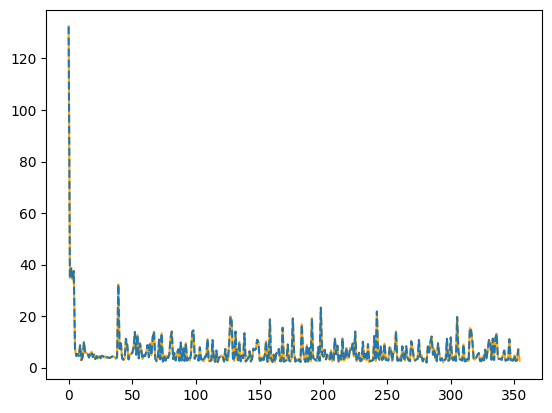

In [119]:
manual_offset = 2
Trial_start_camera_ts_reset = Trial_start_camera_ts[manual_offset::]
plt.plot(np.diff(Trial_start_camera_ts_reset), color = 'orange')
plt.plot(np.diff(poke_data.Trial_Start.unique()),'--')
# plt.xlim([260, 290])
# plt.xlim([0, 50])

(-0.5, 0.5)

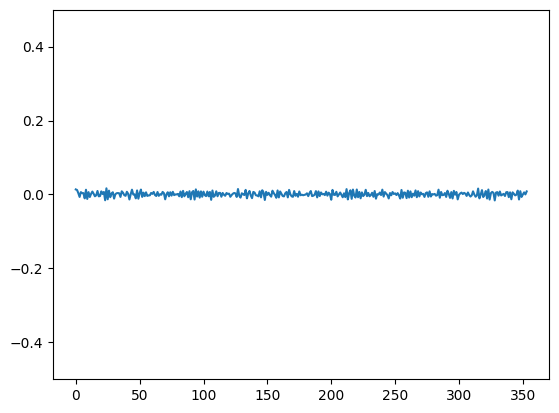

In [167]:
a = Trial_start_camera_ts_reset[0:len(poke_data.Trial_Start.unique())]
b = poke_data.Trial_Start.unique()

plt.plot(np.diff(a) - np.diff(b))

plt.ylim([-0.5, 0.5])


In [172]:
# perform fix: # puts a nan value where it detects ther is a missing trigger
trial_start_bpod_ts = poke_data.Trial_Start.unique()
fixed = test_timestamps_(trial_start_bpod_ts,Trial_start_camera_ts_reset)

fixed_Trial_start_camera_ts = fixed[0:len(trial_start_bpod_ts)]

working
test passed!


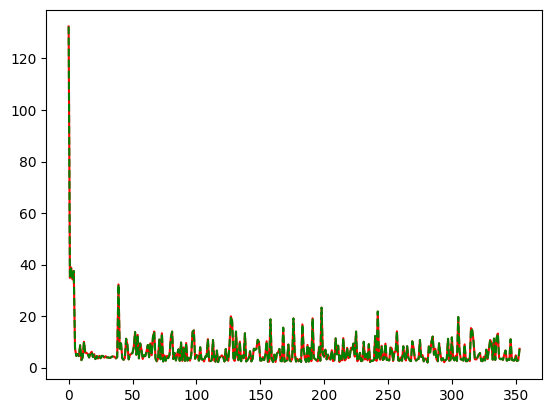

In [173]:
### run tests on fixed data 

plt.plot(np.diff(fixed_Trial_start_camera_ts),color = 'red')
plt.plot(np.diff(poke_data.Trial_Start.unique()), '--', color = 'green')

(-0.5, 0.5)

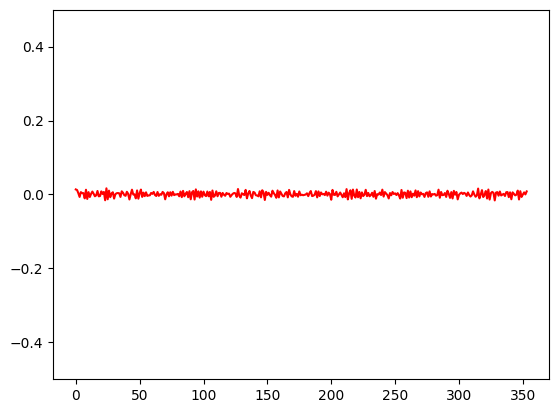

In [174]:
plt.plot(np.diff(fixed_Trial_start_camera_ts) - np.diff(poke_data.Trial_Start.unique()), color = 'red')
plt.ylim([-.5, 0.5])

In [176]:

print('start end diffs')
print('for ephys ts:      '+ str((fixed_Trial_start_camera_ts)[-1] - (fixed_Trial_start_camera_ts)[0]))
print('for behav ts:      ' + str(trial_start_bpod_ts[-1] -  trial_start_bpod_ts[0])) 

count = 0
for item in (np.diff(fixed_Trial_start_camera_ts) - np.diff(poke_data.Trial_Start.unique())):
    if not np.isnan(item):
        count = count + item 
print('ofset tot is:   ' + str(count))


start end diffs
for ephys ts:      2265.8627500000002
for behav ts:      2265.6466
ofset tot is:   0.21615000000008422


In [210]:
def align_to_start_ts(trials,fixed_cam_ts):
    Camera_timestamps = []
    Camera_time = []
    for trial in trials :
        Camera_time.append(fixed_cam_ts[trial-1])
    return Camera_time

## alignment: 
def align_allpokes_to_cam_trialstart(Trials,trial_start_bpod_ts,PokeIn_Time,Fixed_back_cam_tstart_ts):

    cam_poke_times = []
    for index,trial in enumerate(Trials):
        bpod_trial_start = trial_start_bpod_ts[trial-1]
        poke_time = PokeIn_Time[index]
        diff = poke_time - bpod_trial_start
        cam_poke_times += [Fixed_back_cam_tstart_ts[trial-1] + diff]

    return cam_poke_times

In [211]:
### align fixed and checked timestamps:
if not len(poke_data.Trial_id.unique()) == len(fixed_Trial_start_camera_ts):
    print('num trials and trial start TTLs not the same length...this could cause issues')
    
back_aligned_time = align_to_start_ts(poke_data.Trial_id.values,fixed_Trial_start_camera_ts)
back_pokein_times = align_allpokes_to_cam_trialstart(poke_data.Trial_id.values, poke_data.Trial_Start.unique(), poke_data.PokeIn_Time.values,fixed_Trial_start_camera_ts)
back_pokeout_times = align_allpokes_to_cam_trialstart(poke_data.Trial_id.values, poke_data.Trial_Start.unique(), poke_data.PokeOut_Time.values,fixed_Trial_start_camera_ts)


In [219]:
### make a new dataframe:

new_PortIn_df = pd.DataFrame(
    {'Trial_id' : poke_data.Trial_id.values,
     'Trial_Start' : poke_data.Trial_Start.values,
     'Port': poke_data.Port.values,
     'PokeIn_Time': poke_data.PokeIn_Time.values,
     'PokeOut_Time': poke_data.PokeOut_Time.values,
     'Reward_Times': poke_data.Reward_Times.values,
     'Trial_End' : poke_data.Trial_End.values,
     'Port_2-3-4-5_LED_intensities': poke_data['Port 2,3,4,5 LED intensities'].values,
     'Port_1-2-3-4_RewardAmount': poke_data['Port 1,2,3,4 RewardAmount'].values,
     'TrainingLevel': poke_data.TrainingLevel.values,
     
     'TrialStart_EphysTime': poke_data.TrialStart_EphysTime.values,
     'FirstPoke_EphysTime': poke_data.FirstPoke_EphysTime.values,
     'PokeIN_EphysTime': poke_data.PokeIN_EphysTime.values,
     'PokeOUT_EphysTime': poke_data.PokeOUT_EphysTime.values,
    
     'backcam_trialstart_seconds':back_aligned_time,
     'backcam_aligned_pokein_times':back_pokein_times,
     'backcam_aligned_pokeout_times':back_pokeout_times,
     'backcam_trialstart_timestamps':np.array(back_aligned_time)*60
 
    })

In [264]:
poke_data

,Unnamed: 0,Trial_id,Trial_Start,Port,PokeIn_Time,PokeOut_Time,Reward_Times,Trial_End,"Port 2,3,4,5 LED intensities","Port 1,2,3,4 RewardAmount",BACK_Trial_Start_Camera_Time,BACK_Trial_End_Camera_Time,BACK_First_poke_Camera_Time,TrainingLevel,TrialStart_EphysTime,FirstPoke_EphysTime,PokeIN_EphysTime,PokeOUT_EphysTime
0,0,1,15.2224,6,82.7462,82.9945,NaN,147.6291,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",temporary_spacer,temporary_spacer,temporary_spacer,50,6639.485043,NaN,6707.008843,6707.257142837198
1,1,1,15.2224,2,111.4999,111.5000,NaN,147.6291,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",temporary_spacer,temporary_spacer,temporary_spacer,50,6639.485043,6735.695697,6735.762543,6735.762642837199
2,2,1,15.2224,2,111.5002,111.5176,NaN,147.6291,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",temporary_spacer,temporary_spacer,temporary_spacer,50,6639.485043,NaN,6735.762843,6735.780242837198
3,3,1,15.2224,2,111.5219,111.8167,NaN,147.6291,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",temporary_spacer,temporary_spacer,temporary_spacer,50,6639.485043,NaN,6735.784543,6736.079342837198
4,4,1,15.2224,1,113.0116,113.2143,NaN,147.6291,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",temporary_spacer,temporary_spacer,temporary_spacer,50,6639.485043,NaN,6737.274243,6737.476942837198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2694,2694,355,2280.8690,1,2282.0552,2282.1576,NaN,2283.5915,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",temporary_spacer,temporary_spacer,temporary_spacer,50,8903.558855,NaN,8904.745055,8904.84745509355
2695,2695,355,2280.8690,6,2282.4439,2282.4540,NaN,2283.5915,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",temporary_spacer,temporary_spacer,temporary_spacer,50,8903.558855,NaN,8905.133755,8905.143855093549
2696,2696,355,2280.8690,6,2282.4825,2282.5543,NaN,2283.5915,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",temporary_spacer,temporary_spacer,temporary_spacer,50,8903.558855,NaN,8905.172355,8905.24415509355
2697,2697,355,2280.8690,3,2282.8627,2282.9166,NaN,2283.5915,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",temporary_spacer,temporary_spacer,temporary_spacer,50,8903.558855,NaN,8905.552555,8905.60645509355


In [265]:
122.36455000000032/60

2.039409166666672

In [ ]:
8

In [267]:
60+54

114

In [263]:
back_pokein_times

[122.36455000000032,
 151.1182500000003,
 151.1185500000003,
 151.1402500000003,
 152.6299500000003,
 152.9535500000003,
 155.2472500000003,
 155.4566500000003,
 164.7694500000003,
 180.2021500000003,
 180.6112500000003,
 180.7707500000003,
 181.1083500000003,
 182.52445000000031,
 184.2937500000003,
 186.1102500000003,
 190.53330000000048,
 191.66570000000047,
 217.81210000000047,
 218.29170000000047,
 229.47907500000005,
 230.48917500000005,
 263.2293750000006,
 264.13347500000054,
 264.7166750000006,
 266.71377500000057,
 267.9367750000006,
 270.8818750000006,
 271.1464750000006,
 271.37217500000054,
 272.1998750000006,
 280.43007500000056,
 286.23957500000057,
 299.7292000000007,
 302.2286000000007,
 303.4479000000007,
 305.1581000000007,
 305.96630000000073,
 321.2404000000007,
 324.24280000000067,
 325.8320000000007,
 325.89320000000066,
 326.08250000000066,
 328.8445000000007,
 329.53950000000066,
 331.01650000000063,
 331.81000000000074,
 332.18220000000065,
 332.33250000000066

In [235]:
back_pokein_times

[122.36455000000032,
 151.1182500000003,
 151.1185500000003,
 151.1402500000003,
 152.6299500000003,
 152.9535500000003,
 155.2472500000003,
 155.4566500000003,
 164.7694500000003,
 180.2021500000003,
 180.6112500000003,
 180.7707500000003,
 181.1083500000003,
 182.52445000000031,
 184.2937500000003,
 186.1102500000003,
 190.53330000000048,
 191.66570000000047,
 217.81210000000047,
 218.29170000000047,
 229.47907500000005,
 230.48917500000005,
 263.2293750000006,
 264.13347500000054,
 264.7166750000006,
 266.71377500000057,
 267.9367750000006,
 270.8818750000006,
 271.1464750000006,
 271.37217500000054,
 272.1998750000006,
 280.43007500000056,
 286.23957500000057,
 299.7292000000007,
 302.2286000000007,
 303.4479000000007,
 305.1581000000007,
 305.96630000000073,
 321.2404000000007,
 324.24280000000067,
 325.8320000000007,
 325.89320000000066,
 326.08250000000066,
 328.8445000000007,
 329.53950000000066,
 331.01650000000063,
 331.81000000000074,
 332.18220000000065,
 332.33250000000066

In [234]:
143

143

In [231]:
new_PortIn_df

,Trial_id,Trial_Start,Port,PokeIn_Time,PokeOut_Time,Reward_Times,Trial_End,Port_2-3-4-5_LED_intensities,Port_1-2-3-4_RewardAmount,TrainingLevel,TrialStart_EphysTime,FirstPoke_EphysTime,PokeIN_EphysTime,PokeOUT_EphysTime,backcam_trialstart_seconds,backcam_aligned_pokein_times,backcam_aligned_pokeout_times,backcam_trialstart_timestamps
0,1,15.2224,6,82.7462,82.9945,NaN,147.6291,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,6639.485043,NaN,6707.008843,6707.257142837198,54.84075,122.36455,122.61285,3290.445
1,1,15.2224,2,111.4999,111.5000,NaN,147.6291,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,6639.485043,6735.695697,6735.762543,6735.762642837199,54.84075,151.11825,151.11835,3290.445
2,1,15.2224,2,111.5002,111.5176,NaN,147.6291,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,6639.485043,NaN,6735.762843,6735.780242837198,54.84075,151.11855,151.13595,3290.445
3,1,15.2224,2,111.5219,111.8167,NaN,147.6291,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,6639.485043,NaN,6735.784543,6736.079342837198,54.84075,151.14025,151.43505,3290.445
4,1,15.2224,1,113.0116,113.2143,NaN,147.6291,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,6639.485043,NaN,6737.274243,6737.476942837198,54.84075,152.62995,152.83265,3290.445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2694,355,2280.8690,1,2282.0552,2282.1576,NaN,2283.5915,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,8903.558855,NaN,8904.745055,8904.84745509355,2320.70350,2321.88970,2321.99210,139242.210
2695,355,2280.8690,6,2282.4439,2282.4540,NaN,2283.5915,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,8903.558855,NaN,8905.133755,8905.143855093549,2320.70350,2322.27840,2322.28850,139242.210
2696,355,2280.8690,6,2282.4825,2282.5543,NaN,2283.5915,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,8903.558855,NaN,8905.172355,8905.24415509355,2320.70350,2322.31700,2322.38880,139242.210
2697,355,2280.8690,3,2282.8627,2282.9166,NaN,2283.5915,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,8903.558855,NaN,8905.552555,8905.60645509355,2320.70350,2322.69720,2322.75110,139242.210


In [230]:
## run alignment checks! 



port3_inds = [np.where(new_PortIn_df.Port.values == 3)[0][10], np.where(new_PortIn_df.Port.values == 3)[0][int(new_PortIn_df.Trial_id.values[-1]/2)], np.where(new_PortIn_df.Port.values == 3)[0][-5]]
port1_inds = [np.where(new_PortIn_df.Port.values == 1)[0][10], np.where(new_PortIn_df.Port.values == 1)[0][int(new_PortIn_df.Trial_id.values[-1]/2)], np.where(new_PortIn_df.Port.values == 1)[0][-10]]


# Specify the directory
dir_path = r'D:\\camera_test\\'
# Get a list of all files in the directory
files = glob.glob(os.path.join(dir_path, '*'))
# Loop through the files and delete each one
for file in files:
    os.remove(file)
print("All files deleted in the directory:", dir_path)

## create test videos 
avi_files = [f for f in os.listdir(behav_path) if f.endswith('.avi')]
cam_path = behav_path+avi_files[0]

for ind in port1_inds:
    frame_time = back_pokein_times[ind]
    ffmpeg_extract_subclip(cam_path,frame_time - 1,frame_time,targetname=(dir_path +'port1_'+str(ind) + '_back_test.mp4'))
    
for ind in port3_inds:
    frame_time = back_pokein_times[ind]
    ffmpeg_extract_subclip(cam_path,frame_time-1,frame_time,targetname=(dir_path +'port3_'+str(ind) + '_back_test.mp4'))

All files deleted in the directory: D:\\camera_test\\
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


In [145]:
#if alignment is good then save out the data:

out_path = '\\'.join(list(Path(organised_ephys_path).parts[0:-1]))
out_path = out_path + r'\behav_sync\\2_task\\'
print(out_path)

new_PortIn_df.to_csv(out_path +'Behav_Ephys_Camera_Sync.csv')

print('data checked?')
print('data Saved')

Z:\\projects\sequence_squad\revision_data\organised_data\animals\ap5R_implant1\recording7_26-11-2024\behav_sync\\2_task\\


KeyboardInterrupt: 

In [ ]:
Port_intimes = Poke_data_EPhys.PokeIn_Time.values
Port_outtimes = Poke_data_EPhys.PokeOut_Time.values
Ports = Poke_data_EPhys.Port.values

#Determine Transition times and types for all events 
out_in_Transition_times, in_in_Transition_times, Transition_types, out_in_transition_reference,in_in_transition_reference = Determine_Transition_Times_and_Types(Port_intimes,Port_outtimes,Ports)

#Split transtion types into first and last ports: 
start_port_ids = Start_End_port_id(Transition_types,0)
end_port_ids = Start_End_port_id(Transition_types,1)

#Align start and end port time
End_Port_in_time = Port_intimes[1::]
Start_Port_in_time = Port_intimes[0:-1]
End_Port_out_time = Port_outtimes[1::]
Start_Port_out_time = Port_outtimes[0:-1]

#Find Port repeat events (double pokes)
Non_Port_repeat = determine_RepeatPort_events(start_port_ids,end_port_ids)

#Determine which transitions are good: less than 1.5s
out_in_Filtered_transitions = filter_transitons_by_latency(out_in_Transition_times, 2)
in_in_Filtered_transitions = filter_transitons_by_latency(in_in_Transition_times, 2)

In [ ]:
# make dataframe:
new_Transition_df = pd.DataFrame(
    {'Trial_id' : Poke_data_EPhys['Trial_id'][0:-1],
    'Transition_type' : Transition_types,
     'Start_Port':start_port_ids, 
     'End_Port':end_port_ids,
     'Start_Poke_in_time': Start_Port_in_time,
     'Start_Poke_out_time': Start_Port_out_time,
     'End_Poke_in_time': End_Port_in_time,
     'End_Poke_out_time': End_Port_out_time,
     'out_in_Latency' : out_in_Transition_times,
     'in_in_Latency': in_in_Transition_times,
     '2s_Time_Filter_out_in': out_in_Filtered_transitions,
     '2s_Time_Filter_in_in': in_in_Filtered_transitions,
     'Port_2-3-4-5_LED_intensities': Poke_data_EPhys['Port 2,3,4,5 LED intensities'].values[0:-1],
     'Port_1-2-3-4_RewardAmount': Poke_data_EPhys['Port 1,2,3,4 RewardAmount'].values[0:-1],
     'Repeat_Filter':Non_Port_repeat,
     
     'TrialStart_EphysTime': Poke_data_EPhys.TrialStart_EphysTime.values[0:-1],
     'FirstPoke_EphysTime': Poke_data_EPhys.FirstPoke_EphysTime.values[0:-1],
     'P1_IN_Ephys_TS': Poke_data_EPhys.PokeIN_EphysTime.values[0:-1],
     'P1_OUT_Ephys_TS': Poke_data_EPhys.PokeOUT_EphysTime.values[0:-1],
     'P2_IN_Ephys_TS': Poke_data_EPhys.PokeIN_EphysTime.values[1::],
     'P2_OUT_Ephys_TS': Poke_data_EPhys.PokeOUT_EphysTime.values[1::],
     
     'backcam_trialstart_seconds':back_aligned_time[0:-1],
     'backcam_trialstart_timestamps':back_aligned_ts[0:-1],  
     'backcam_aligned_P1In_times':back_pokein_times[0:-1],
     'backcam_aligned_P1Out_times':back_pokeout_times[0:-1],
     'backcam_aligned_P2In_times':back_pokein_times[1::],
     'backcam_aligned_P2Out_times':back_pokeout_times[1::],
     
    
    })

In [ ]:
new_Transition_df.to_csv(out_path +'Transition_data_sync.csv')

print('data checked?')
print('data Saved')